# Poisson regression

In [45]:
import pymc3 as pm
import pandas as pd 
import numpy as np 

Replicate the monkey killing example from 705. This is to showcase how to fit a generalized linear regression with certain link functions and families. Here's the data first. 

In [2]:
ache_hunting = '''
67 0 3 66 0 89 63 29 106 60 2 4
61 0 28 59 2 73 58 3 7 57 0 13
56 0 4 56 3 104 55 27 126 54 0 63
51 7 88 50 0 7 48 3 3 49 0 56
47 6 70 42 1 18 39 0 4 40 7 83
40 4 15 39 1 19 37 2 29 35 2 48
35 0 35 33 0 10 33 19 75 32 9 63
32 0 16 31 0 13 30 0 20 30 2 26
28 0 4 27 0 13 25 0 10 22 0 16
22 0 33 21 0 7 20 0 33 18 0 8
17 0 3 17 0 13 17 0 3 56 0 62
62 1 4 59 1 4 20 0 11
'''

In [44]:
arr = []
for line in ache_hunting.splitlines():
    if line:
        line_ = line.split(' ')
        line_ = [float(i) for i in line_]
        arr.extend(line_)
    
age = [arr[i] for i in range(len(arr)) if i%3==0]
kills = [arr[i] for i in range(len(arr)) if i%3==1]
days = [arr[i] for i in range(len(arr)) if i%3==2]
ache_df = pd.DataFrame({'age':age, 'kills':kills, 'days':days})
ache_df.head()

,age,kills,days
0,67.0,0.0,3.0
1,66.0,0.0,89.0
2,63.0,29.0,106.0
3,60.0,2.0,4.0
4,61.0,0.0,28.0


At each point in the range of the data set a low-degree polynomial is fitted to a subset of the data, and this method is used initially for scatterplot smoothing. Here's plot of the rate.

Text(0.5, 1.0, 'scatter plot and lowess plot')

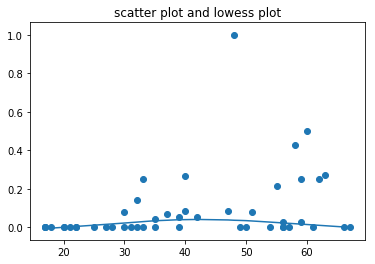

In [66]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

x_days = ache_df.age.values
y_rates = ache_df.kills.values/ache_df.days.values
f = plt.figure()
axes = f.add_subplot(1,1,1)
axes.scatter(x_days, y_rates)

predicted = sm.nonparametric.lowess(y_rates, x_days, frac=0.7)
axes.plot(predicted[:, 0], predicted[:, 1])
axes.set_title('scatter plot and lowess plot')

In [67]:
from statsmodels.genmod.families.links import log as log_link
import statsmodels.formula.api as smf

m = smf.glm('kills ~ age + np.power(age, 2)', 
            data=ache_df,
            offset=np.log(ache_df['days']),
            family=sm.families.Poisson(link=log_link())).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  kills   No. Observations:                   47
Model:                            GLM   Df Residuals:                       44
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -124.89
Date:                Fri, 11 Jan 2019   Deviance:                       186.01
Time:                        14:04:43   Pearson chi2:                     198.
No. Iterations:                     6   Covariance Type:             nonrobust
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -5.4842      1.245     -4.406      0.000      -7.924      -3.045
age                  0.1246      0.057      2.196      0.028       0.013       0.236
np.power(age, 2)    -0.0012      0.001     -1.943      0.052      -0.002    1.04e-05
====================================================================================
"""

## here's some diagnosis
there's a method to sort of standardize residuals so that they comform a certain kind of distribution. One common method is pearson residual, which is calculated by dividing the raw residuals with square root of predicted values. This graph can be used to spot ill-fitted points.

In [86]:
np.allclose(m.resid_pearson, (ache_df.kills - m.fittedvalues )/np.sqrt(m.fittedvalues))

True

<StemContainer object of 3 artists>

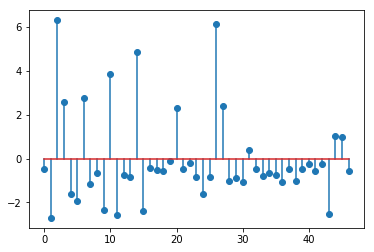

In [92]:
#make a plot that's kinda like cook's distance
plt.stem(m.resid_pearson, markerfmt='o')

In [106]:
#this statistic is used to find out the chi square test result
chi_square_stat = np.sum(np.square(m.resid_pearson))
built_in = m.pearson_chi2

1. The residual plot (pearson residual should roughly go around a straight line. The line can be implemented by smoothing (local regression).
2. if it's pearson residual or studentized pearson residuals, the points are supposed to be spreading out evenly and a megaphone shape is not OK.
3. The distribution assumption of possion residuals are based on normal approximation (the second bullet point), which means the condition for approximation has to be satisfied. For Poisson distribution, the lamdba has to be large enough. And thus approximation might have problems for accounts around zero!

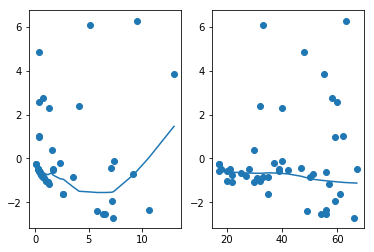

In [121]:
f, [ax1, ax2] = plt.subplots(1, 2)
ax1.scatter(m.fittedvalues, m.resid_pearson)
ax2.scatter(ache_df.age.values, m.resid_pearson)

predicted = sm.nonparametric.lowess(m.resid_pearson, m.fittedvalues)
ax1.plot(predicted[:, 0], predicted[:, 1])

predicted2 = sm.nonparametric.lowess(m.resid_pearson, ache_df.age.values)
ax2.plot(predicted2[:, 0], predicted2[:, 1])

The above figure has an issue: the variances is too high! Note that Pearson residuals should have variances smaller than 1. This extra Poisson variability is referred as overdispersion.